Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [2]:
import logging
from itertools import combinations, accumulate
import pandas as pd
import numpy as np
import geopy.distance
import networkx as nx
import functools
from icecream import ic
from dataclasses import dataclass
import random
import itertools
from math import ceil
import matplotlib.pyplot as plot

logging.basicConfig(level=logging.DEBUG)

# Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

### Collection of cities, divided by country

In [3]:
countries=[
    

    {
        'name': 'Vanuatu',
        'cities': pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon']),
        'dist_matrix':[]
    },

    {
        'name':'Italy',
        'cities':pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon']),
        'dist_matrix':[]
    },

    {
        'name':'Russia',
        'cities': pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon']),
        'dist_matrix':[]
    },

    
    {
        'name':'USA',
        'cities':pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon']),
        'dist_matrix':[]
    },
    
    {
        'name':'China',
        'cities': pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon']),
        'dist_matrix':[]
    },
]




### Distance matrix calculation

In [4]:
for country in countries:
    cities=country['cities']
    dist_matrix = np.zeros((len(cities), len(cities)))
    for c1, c2 in combinations(cities.itertuples(), 2):
        dist_matrix[c1.Index, c2.Index] = dist_matrix[c2.Index, c1.Index] = geopy.distance.geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    country['dist_matrix']=dist_matrix

## TSP solutions
Countries indexes:
+ 0: Vanuatu
+ 1: Italy
+ 2: Russia
+ 3: USA
+ 4: China

#### Utility functions

In [5]:
def tsp_validation(cities,sol):

    '''
    Checks the validity of the given solution.
    The tsp problem is solved if:
    1) The solution covers all the cities
    2) The solution is a cycle
    '''

    #tsp mut be a cycle
    assert sol[0]==sol[-1]

    #the tsp must cover all the cities
    assert set(sol)==set(range(len(cities)))

def cost(sol,dist_matrix):
    '''
    Return the cost of the given tsp solution. given the distance matrix
    '''

    cost = 0
    for c1, c2 in zip(sol, sol[1:]):
        cost += dist_matrix[c1, c2]
    return cost

### Proposed soltion 1
Implementing a fast greedy algorithm

#### Greedy TSP definition

In [6]:
def tsp_greedy(cities,distance_matrix):

    visited = np.full(len(cities),False)
    start = 0
    current_city = start
    dist=np.copy(distance_matrix)
    visited[start]=True
    voyage=[]
    voyage.append(start)
    journey_diary=''
    steps = 0

    while not np.all(visited):

        dist[: ,current_city]=np.inf
        distance_vector = dist[current_city]
        next_stop=np.argmin(distance_vector)
        voyage.append(next_stop)
        
        journey_diary += f'Start: {cities.at[current_city,'name']} --> Arrival: {cities.at[next_stop,'name']} || Kilometers travelled: {distance_vector[next_stop]:.2f}\n'
        steps+=1
        current_city=next_stop
        visited[current_city]=True
    
    voyage.append(0)
    journey_diary += f'Finally going home!\t Start: {cities.at[voyage[-2],'name']} --> Arrival: {cities.at[0,'name']} || Kilometers travelled: {distance_matrix[voyage[-2],0]:.2f}\n'
    journey_diary += f'Total kilometers travelled: {cost(voyage,distance_matrix):.2f}\n'
    journey_diary += f'Total numer of "steps": {steps}'

    return (voyage,journey_diary)



#### Solving the TSP
The solutions are stored in a txt file

In [6]:
for country in countries:
    print(f'Now doing: {country['name']}')
    
    (greedy_voyage,greedy_diary)=tsp_greedy(country['cities'],country['dist_matrix'])
    with open(f'{country['name']} greedy voyage journal.txt','w',encoding='UTF-8') as f:
        f.write(greedy_diary)


Now doing: Vanuatu
Now doing: Italy
Now doing: Russia
Now doing: USA
Now doing: China


### Proposed solution 2

In [69]:
COUNTRY = 2
INDIVIDUALS = 512
GENERATIONS = 50000
TAU = 32
COSTS = countries[COUNTRY]['dist_matrix']

#### Genetic algorithms at genotype-level: definition of individual, fitness, mutations and crossover strategies

In [24]:
@dataclass
class individual:
    genome: np.ndarray
    
    def fitness(self):
        return -float(cost(self.genome,COSTS))

def mutation(subject: np.ndarray):

    '''
    Performs the insert and inversion mutations with a given probability
    '''

    def inversion(subject:np.ndarray):
        '''
        Performs inversion mutation for the given individual, and returns the inidividual whith the mutated genome
        '''
        if len(subject) > 2:
            start_cut = np.random.randint(1, len(subject) - 1)  # Start and end points are fixed
        else:
            # Handle the case where the genome length is too short for this operation
            raise ValueError('Genome length must be greater than 2 to select a valid cut point.')
        
        end_cut=np.random.randint(1,len(subject)-1)
        
        while end_cut == start_cut:
            end_cut=np.random.randint(1,len(subject)-1)
                
        
        if(start_cut>end_cut):
            start_cut,end_cut=end_cut,start_cut

        mutated_genome=subject[0:start_cut]
        mutated_genome=np.append(mutated_genome,subject[start_cut:end_cut][::-1])
        mutated_genome=np.append(mutated_genome,subject[end_cut:])

        subject=mutated_genome
        return subject
    
    def insert(subject):
        '''
        Performs the "insert" mutation for the given individual
        '''

        first_allele=np.random.randint(1,len(subject)-1)
        
        second_allele=None
        while second_allele==first_allele or second_allele is None:
            second_allele=np.random.randint(1,len(subject)-1)
        
        if first_allele>second_allele:
            first_allele,second_allele=second_allele,first_allele   #if the second allele position is before the first one swap the two elements
        
        mutated_genome=subject[0:first_allele+1]
        mutated_genome=np.append(mutated_genome,subject[second_allele])
        mutated_genome=np.append(mutated_genome,subject[first_allele+1:second_allele])
        mutated_genome=np.append(mutated_genome,subject[second_allele+1:])

        subject=mutated_genome
        return subject
    

    mutation_probability = 1/len(subject)

    if random.random() < mutation_probability:
        subject=insert(subject)

    
    if random.random() < mutation_probability:
        subject=inversion(subject)

    return individual(subject)

def IOX(P1: np.ndarray, P2: np.ndarray):
    '''
    Implements the Inver Over Crossover strategy
    From P1 we will take the sequence genes
    From P2 we will take the the end edge
    '''

    def cyclic_extraction(v : np.ndarray, start:int, end: int):
        cyclic_slice=v[start+1:]
        return np.append(cyclic_slice,v[0:end])

    #if random.random()<0.5:     #parent selection randomization
    #    P1,P2=P2,P1
    
    P1_start_edge=np.random.randint(0,len(P1)-1)
    P2_start_edge=np.argwhere(P2==P1[P1_start_edge])[0][0]
    P2_end_edge = (P2_start_edge + 1)%len(P2)
    P1_end_edge = np.argwhere(P1==P2[P2_end_edge])[0][0]
    
    
    if P1_start_edge < P1_end_edge:
        child=P1[0:P1_start_edge]
        child=np.append(child,P2[P2_start_edge])
        child=np.append(child,P2[P2_end_edge])
        child=np.append(child,P1[P1_start_edge+1:P1_end_edge][::-1])
        child=np.append(child,P1[P1_end_edge+1:])

    else:
        child=P1[P1_end_edge+1:P1_start_edge]
        child=np.append(child,P2[P2_start_edge])
        child=np.append(child,P2[P2_end_edge])
        child=np.append(child,cyclic_extraction(P1,P1_start_edge,P1_end_edge)[::-1])
    
    if len(child)!=len(P1):
        print(f'P1: {P1}')
        print(f'P2: {P2}')
        print(f'Child: {child}')
        print(f'P1 start: {P1_start_edge}')
        print(f'P1 end: {P1_end_edge}')
        print(f'P2 start: {P2_start_edge}')
        print(f'P2 end: {P2_end_edge}')

    return child

def PMX(P1: individual, P2: individual):

    P1_g = P1.genome
    P2_g = P2.genome

    L1=np.random.randint(1,len(P1_g)-1)
    L2=np.random.randint(1,len(P1_g)-1)

    if L1 < L2:
        L1,L2=L2,L1

    
    mapping=np.vstack((P1_g[L1:L2+1],P2_g[L1:L2+1]))

    offspring=np.array([])

    print(mapping)

    for idx,gene in enumerate(P2):
        
        if idx >= L1 and idx <=L2:
            offspring=np.append(offspring,P1_g[idx])
            continue
        
        if gene in mapping[0]:
            gene_index = np.argwhere(mapping[0]==gene)[0][0]
            proposed_gene= mapping[1][gene_index]
            while proposed_gene in mapping[0]:
                gene_index = np.argwhere(mapping[0]==proposed_gene)[0][0]
                proposed_gene = mapping[1][gene_index]
                
            offspring=np.append(offspring,mapping[1][gene_index])
        else:
            offspring=np.append(offspring, gene)

    return offspring

def multipunctual_mutation(subject: np.ndarray):
    
    mutation_nr = ceil(len(subject)/10)

    for _ in range(mutation_nr):
        allele1=np.random.randint(1,len(subject)-1)
        allele2=np.random.randint(1,len(subject)-1)

        while allele2==allele1:
            allele2=np.random.randint(1,len(subject)-1)
            
        subject[allele1],subject[allele2]=subject[allele2],subject[allele1]
    
    return individual(np.array(subject))

#### Genetic algorithms at population level: population definition, parent selection and offspring selection

In [44]:
@dataclass
class population:
    parents: np.ndarray
    offspring: np.ndarray


def tournament_selection(candidates: population, tau: int):
    '''
    Implements the tournament selection as parent selection for the EA
    '''
    parents = candidates.parents
    selected_parents = np.array([])

    while len(parents) > 0:
        match_partecipants=[]
        while len(match_partecipants) < tau and len(parents) > 0:
            chosen_idx = np.random.randint(0,len(parents))
            match_partecipants.append(parents[chosen_idx])
            parents = np.delete(parents,chosen_idx)
        
        selected_parents = np.append(selected_parents,sorted(match_partecipants,key= lambda ind:ind.fitness())[-1])
        candidates.parents=selected_parents
    return

def create_offspring(pop:population):

    def create_pairs(parents:np.ndarray):
        
        pairs = []

        while len(parents)>0:
            p1 = np.random.randint(0,len(parents))
            parent_1 = parents[p1]
            parents=np.delete(parents,p1)
            p2 = np.random.randint(0,len(parents))
            pairs.append((parent_1,parents[p2]))
            parents=np.delete(parents,p2)

        return np.array(pairs)

    offspring = []
    parents_pairs = create_pairs(np.copy(pop.parents))


    while(len(pop.parents)+len(offspring))<INDIVIDUALS:
        for pair in parents_pairs:
            mutated_genome=IOX(pair[0].genome[1:-1],pair[1].genome[1:-1])
            mutated_genome=np.insert(mutated_genome,0,0)
            mutated_genome=np.append(mutated_genome,0)
            offspring.append(mutated_genome)
        
    no=[]
    for child in offspring:
        no.append(mutation(child))


    new_population=population(pop.parents,np.array(no))
    return new_population

def create_population(pop:population, init=False, greedy_solution=None):
    '''
    Creates the base popuation, derived by a preceding population and an offspring, or by a greedy starting solution if there is none
    If the init parameter is set the function requires an initial greedy solution from which it can create the initial population
    '''

    new_population=[]

    if init:

        if greedy_solution is None:
            raise ValueError('Initial population requires a greedy solution to start from!')
        for _ in range(INDIVIDUALS):
            new_ind=multipunctual_mutation(np.copy(greedy_solution))
            new_population.append(new_ind)
        
        
        new_pop=population(np.array(new_population),np.array([]))
        
    else:
        new_pop_this_way_works=np.append(pop.parents,pop.offspring)
        new_pop=population(new_pop_this_way_works,np.array([]))

    return new_pop
        

#### Evolutionary Algorithm

In [61]:
def EA(country):

    def evolutionary_cycle(population:population):
        population=create_offspring(population)
        new_population = create_population(population)
        tournament_selection(new_population,TAU)
        return new_population
    
    initial_greedy=tsp_greedy(country['cities'],country['dist_matrix'])[0]
    ic(individual(initial_greedy).fitness())
    
    pop = population(np.array([]),np.array([]))
    pop = create_population(pop,init=True,greedy_solution=initial_greedy)

    plot.figure(figsize= (14, 8))
    history = []

    for _ in range(GENERATIONS):
        pop=evolutionary_cycle(pop)
        best_ind = sorted(pop.parents, key= lambda ind:ind.fitness())[-1]
        history.append(best_ind.fitness())
    
    
    ic(np.array(history).max())
    plot.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color ="red",
    )

    _ = plot.scatter(range(len(history)), history, marker = ".")




#### Solving the TSP

ic| individual(initial_greedy).fitness(): -42334.16465744784
ic| np.array(history).max(): np.float64(-37026.32380561279)


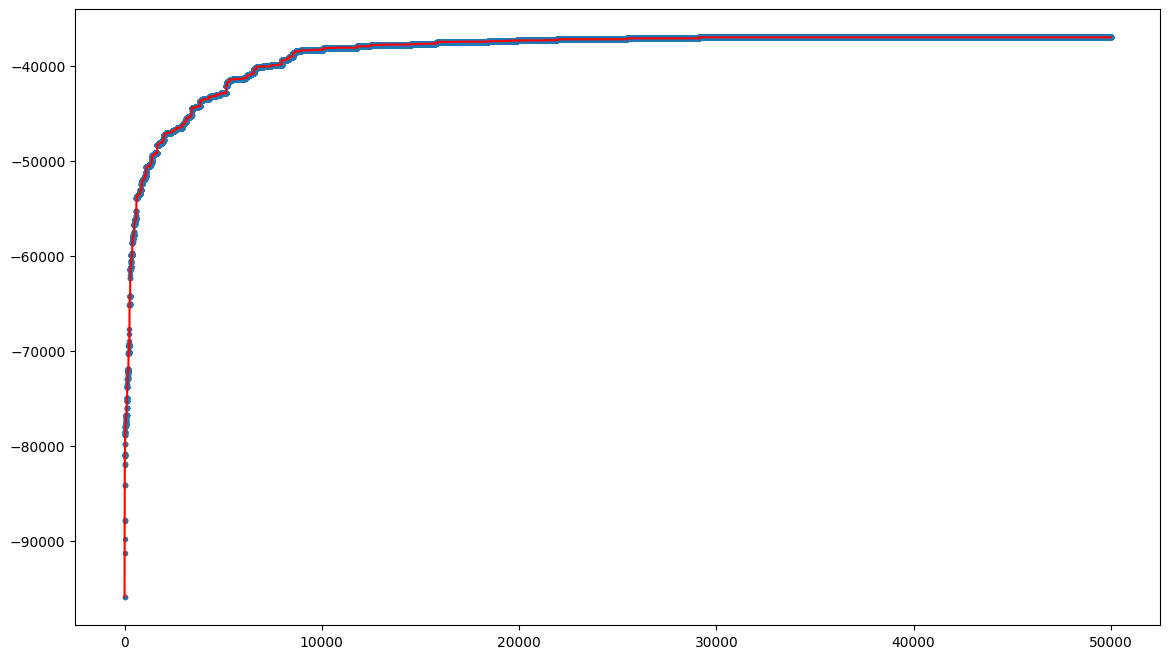

In [70]:
country=countries[COUNTRY]
EA(country)

In [71]:
COUNTRY = 3
INDIVIDUALS = 1024
GENERATIONS = 100000
TAU = 32
COSTS = countries[COUNTRY]['dist_matrix']

ic| individual(initial_greedy).fitness(): -48050.02586446137
ic| np.array(history).max(): np.float64(-42282.44278895262)


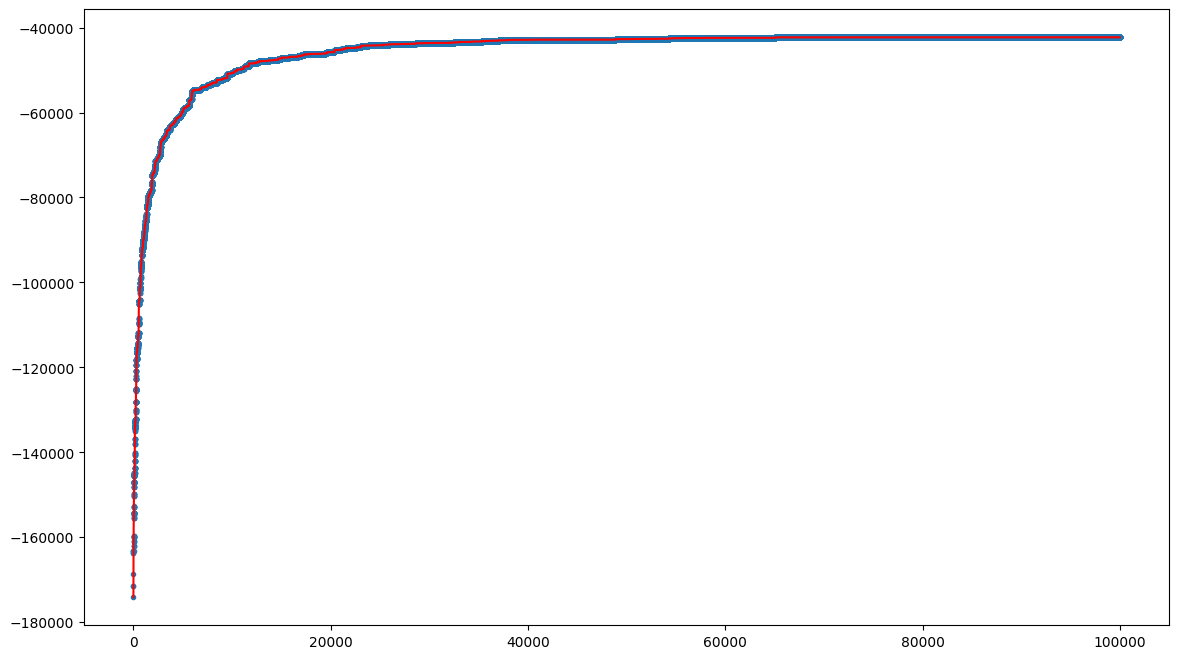

In [72]:
country=countries[COUNTRY]
EA(country)

In [73]:
COUNTRY = 4
INDIVIDUALS = 1024
GENERATIONS = 100000
TAU = 32
COSTS = countries[COUNTRY]['dist_matrix']

ic| individual(initial_greedy).fitness(): -63962.9184294552
ic| np.array(history).max(): np.float64(-67936.97765362408)


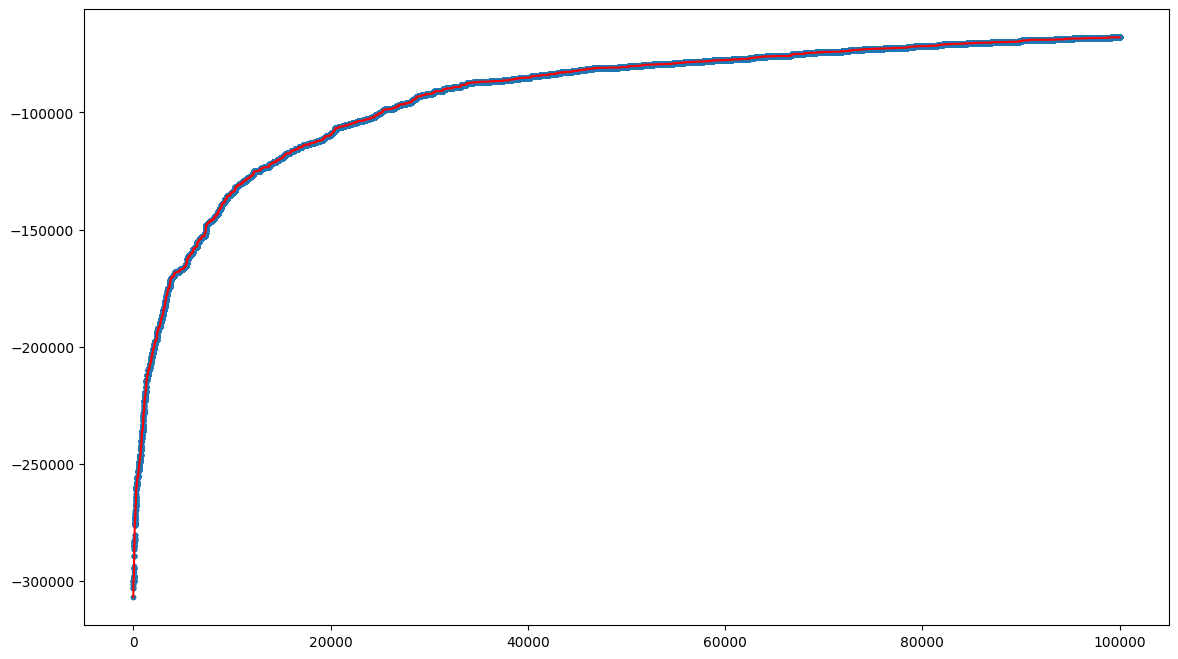

In [74]:
country=countries[COUNTRY]
EA(country)